### Importing Important Library

In [11]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.legacy.datasets import IMDB
from torchtext.legacy.data import Field, LabelField, BucketIterator

In [13]:
from tqdm import tqdm
import random
import sys

### Version chcek

In [14]:
f'Torch CUDA Version :{torch.version.cuda}'
f'Torch Version :{torch.__version__}'
f'Python Version :{sys.version}'

'Torch CUDA Version :10.1'

'Torch Version :1.8.1+cu101'

'Python Version :3.7.10 (default, May  3 2021, 02:48:31) \n[GCC 7.5.0]'

### GPU Checker 

In [15]:
def gpu_check(seed_val = 1):
    print('The Seed is set to {}'.format(seed_val))
    if torch.cuda.is_available():
        print('Model will Run on CUDA.')
        print ("Type 'watch nvidia-smi' to monitor GPU\n")
        torch.cuda.manual_seed(seed_val)
        device = 'cuda'
    else:
        torch.manual_seed(seed_val)
        print ('Running in CPU')
        device = 'cpu'
    cuda = torch.cuda.is_available()
    return cuda,seed_val,device

In [16]:
cuda,SEED,device = gpu_check(seed_val=1234)

The Seed is set to 1234
Model will Run on CUDA.
Type 'watch nvidia-smi' to monitor GPU



In [17]:
!nvidia-smi

Wed May 26 06:45:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [18]:
def tokenize(s):
    return s.split(' ')

### Removing spacy for faster execution and loading custion tokenizer

In [19]:
TEXT = Field(tokenize = 'spacy',tokenizer_language = 'en_core_web_sm', lower = True)
# TEXT = Field(tokenize = tokenize,tokenizer_language = 'en_core_web_sm', lower = True)
LABEL = LabelField(dtype = torch.float)

### Creating the data split 

In [20]:
train_data, test_data = IMDB.splits(TEXT, LABEL,root ='./')

aclImdb_v1.tar.gz:   0%|          | 115k/84.1M [00:00<01:13, 1.14MB/s]

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:01<00:00, 76.6MB/s]


In [21]:
train_data, valid_data = train_data.split(random_state = random.seed(SEED))

In [22]:
# display lenght of test and traing data
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 17500
Number of testing examples: 25000


In [23]:
# display single example at index 0
print(vars(train_data.examples[0]))

{'text': ['most', 'book', 'adaptations', 'are', 'bad', 'but', 'this', 'film', 'left', 'out', 'key', 'parts', 'of', 'the', 'storyline', 'and', 'changed', 'the', 'description', 'and', 'some', 'characters', '.', 'they', 'rewired', 'the', 'storyline', 'and', 'combined', 'scenes', 'and', 'changed', 'the', 'order', '.', 'they', 'added', 'ridiculous', 'things', 'into', 'it', 'that', 'never', 'happened', 'in', 'the', 'book', 'and', 'would', 'never', 'happen.<br', '/><br', '/>if', 'i', 'had', "n't", 'read', 'the', 'book', 'beforehand', 'it', 'would', 'have', 'been', 'an', 'incredibly', 'dull', 'film', ',', 'it', 'did', "n't", 'make', 'you', 'care', 'about', 'the', 'characters', ',', 'like', 'them', 'or', 'dislike', 'them', '.', 'it', 'turns', 'the', 'characters', 'into', 'jokes.<br', '/><br', '/>awful.<br', '/><br', '/>ridiculous.<br', '/><br', '/>waste', 'of', 'two', 'hours', 'of', 'my', 'life', '.'], 'label': 'neg'}


### Visualizing the data

In [24]:
line = ''
filenumber = 11

for i in train_data.examples[filenumber].text:
    line += i + ' '
line

train_data.examples[filenumber].label

"i loved this movie from the opening sequence right through to the end . i found the director/ actor 's style of directly addressing me / the audience very engaging.<br /><br />what i found most exciting and refreshing about this movie was its ignoring -- and thus challenging -- of gender and class stereotypes . the idiosyncrasies of the characters are portrayed as strengths , and the absence of judgment -- and the characters ' acceptance of themselves and each other -- enabled me to embrace them and allow myself to be drawn into their world . without preaching , and with intelligence and gentle and loving humor , this movie has the power to open us to new possibilities , and offers hope for a world in which people see and accept each other as unique and precious individuals . i look forward to more offerings from this creative and talented director . "

'pos'

###  Build vocabulary for source and target from training data
 

In [25]:
# Build vocabulary for source and target from training data

TEXT.build_vocab(train_data, max_size=25_000)
LABEL.build_vocab(train_data)


In [26]:

# print(vars(TEXT.vocab))
print(f"Unique tokens in source vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in TRG vocabulary: {len(LABEL.vocab)}")

Unique tokens in source vocabulary: 25002
Unique tokens in TRG vocabulary: 2


### train and test iteartor

In [27]:

BATCH_SIZE = 32
train_iterator,valid_iterator ,test_iterator = BucketIterator.splits(
      (train_data, valid_data,test_data), 
      batch_size = BATCH_SIZE, 
      device = device
    )

### Creating Model

In [28]:
# Model class
class Model(nn.Module):
    def __init__(self, input_dim, output_dim,emb_dim, hidden_dim, n_layers, dropout):
        # input_dim <--- vocabulary size
        # output_dim <--- len ([positive, negative]) == 2 
        # emb_dim <--- embedding dimension of embedding matrix

        super(Model, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hidden_dim, n_layers, dropout=dropout)
        self.fc1 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # shape: [source_len, batch_size]
        embedded = self.dropout(self.embedding(src)) # shape: [src_len, batch_size, embed_dim]
        output, (hidden, cell) = self.rnn(embedded) 
        # output shape -> [batch, hidden_dim]
        # hiddden shape -> [n_layers, batch, hidden_dim]
        # cell shape -> [n_layers, batch, hidden_dim]
        output = self.fc1(output[-1])
#         output = self.fc2(self.relu(output))
        return output

In [29]:
#initializing variables and hyper parameters
INPUT_DIM = len(TEXT.vocab)
OUTPUT_DIM = len(LABEL.vocab)

EMBEDDING_DIM = 100
DEC_EMB_DIM = 100
HIDDEN_DIM = 256

N_LAYERS = 1
DROPOUT = 0.6

# initializing our model
model = Model(INPUT_DIM, OUTPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT).to(device)



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [30]:
train_loss = []
train_accuracy = []

In [31]:
# loop and train our model
optimizer = optim.Adam(model.parameters(), lr=3e-3)

# defining learnig rate scheduler (optional)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

criterion = nn.CrossEntropyLoss()


### Model training function

In [32]:

def train(EPOCH,model, iterator, optimizer=optimizer, criterion=criterion, clip=1,):
    model.train()
    epoch_loss = 0
    total_correct = 0
    total_count = 0
    pbar = tqdm(iterator)
    for i, batch in enumerate(pbar):
        src = batch.text.to(device)
        trg = batch.label.to(device)
        trg = trg.long()
        optimizer.zero_grad()
        output = model(src)
        
        total_correct += torch.sum(torch.eq(output.argmax(1), trg))
        total_count+=len(trg)
        
        loss = criterion(output, trg)
        
        loss.backward() 
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        pbar.set_description(desc= f'Epoch {EPOCH} Train data Batch No : {i} Loss : {loss.item():.3f} Accuracy : {total_correct/total_count * 100 :.2f}% ' )
    
    train_accuracy.append(total_correct/total_count)
    mean_loss = epoch_loss / len(iterator)
    train_loss.append(mean_loss)
    
    scheduler.step(mean_loss)
    

### Model Validation function

In [33]:
test_loss = []
test_accuracy = []
validation_loss = []
validation_accuracy = []

In [34]:
def evaluate(EPOCH,model, iterator, criterion,typ_loader):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    pbar  = tqdm(iterator)
    with torch.no_grad():
        
        for i,batch in enumerate(pbar):
            src = batch.text.to(device)
            trg = batch.label.to(device)
            trg = trg.long()
            predictions = model(src)
            
            loss = criterion(predictions, trg)
            
            acc = binary_accuracy(predictions, trg)

            epoch_loss += loss.item()
            epoch_acc += acc
            if typ_loader == 'Valid data':
                validation_loss.append(loss)
                validation_accuracy.append(acc)
            elif typ_loader == 'Test data':
                test_loss.append(loss)
                test_accuracy.append(acc)

            pbar.set_description(desc= f'Epoch {EPOCH} {typ_loader} Batch No : {i} Loss : {loss.item():.3f} Accuracy : {epoch_acc / len(iterator)* 100 :.2f}% ' )

In [35]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds.argmax(1) == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc.item()

In [57]:

total_epoch = 10
for epoch in range(total_epoch):
    result = train(epoch,model=model, iterator=train_iterator)
    evaluate(epoch,model,valid_iterator,criterion,'Valid data')
    evaluate(epoch,model,test_iterator,criterion,'Test data')
    

Epoch 0 Train data Batch No : 546 Loss : 0.560 Accuracy : 63.38% : 100%|██████████| 547/547 [00:39<00:00, 13.97it/s]
Epoch 0 Valid data Batch No : 234 Loss : 1.076 Accuracy : 58.87% : 100%|██████████| 235/235 [00:02<00:00, 96.49it/s]
Epoch 0 Test data Batch No : 781 Loss : 1.146 Accuracy : 58.08% : 100%|██████████| 782/782 [00:07<00:00, 100.07it/s]
Epoch 1 Train data Batch No : 546 Loss : 0.582 Accuracy : 64.92% : 100%|██████████| 547/547 [00:39<00:00, 13.96it/s]
Epoch 1 Valid data Batch No : 234 Loss : 0.598 Accuracy : 60.56% : 100%|██████████| 235/235 [00:02<00:00, 97.36it/s]
Epoch 1 Test data Batch No : 781 Loss : 0.458 Accuracy : 60.02% : 100%|██████████| 782/782 [00:07<00:00, 100.21it/s]
Epoch 2 Train data Batch No : 546 Loss : 0.611 Accuracy : 65.27% : 100%|██████████| 547/547 [00:39<00:00, 14.02it/s]
Epoch 2 Valid data Batch No : 234 Loss : 0.844 Accuracy : 62.34% : 100%|██████████| 235/235 [00:02<00:00, 96.57it/s]
Epoch 2 Test data Batch No : 781 Loss : 0.870 Accuracy : 61.88% 

Text(0.5, 1.0, 'train_acc')

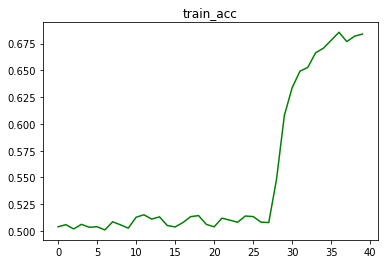

In [58]:
import matplotlib.pyplot as plt

plt.plot(train_accuracy,'green')
plt.title('train_acc')

Text(0.5, 1.0, 'train_loss')

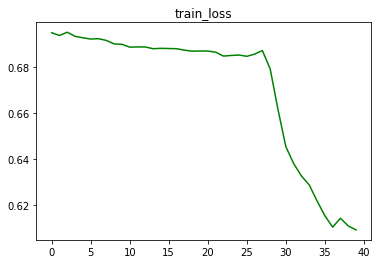

In [59]:
plt.plot(train_loss,'green')
plt.title('train_loss')

Text(0.5, 1.0, 'test_acc')

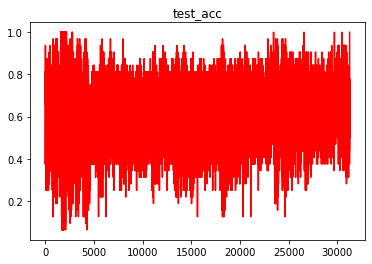

In [60]:
plt.plot(test_accuracy,'red')
plt.title('test_acc')

Text(0.5, 1.0, 'test_loss')

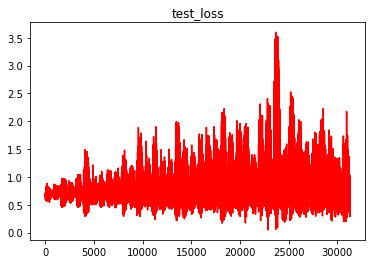

In [61]:
plt.plot(test_loss,'red')
plt.title('test_loss')

Text(0.5, 1.0, 'test_acc')

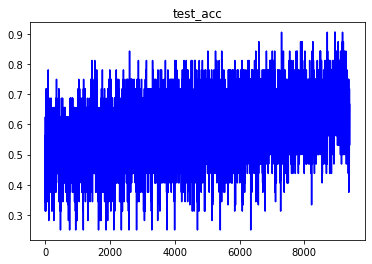

In [62]:

plt.plot(validation_accuracy,'blue')
plt.title('test_acc')

Text(0.5, 1.0, 'test_loss')

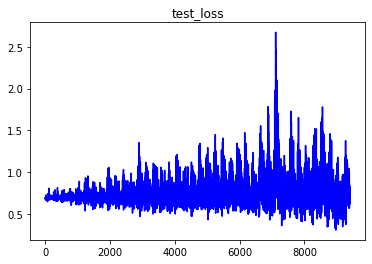

In [63]:
plt.plot(validation_loss,'blue')
plt.title('test_loss')

### function to experiment movie review sentences

In [43]:

import spacy
sp = spacy.load('en_core_web_sm')


def predict(sentence):
    if type(sentence) == str:
        tokanized_sentence = [word.text for word in sp.tokenizer(sentence)]
    else:
        tokanized_sentence = sentence


    input_data = [TEXT.vocab.stoi[word.lower()] for word in tokanized_sentence]
    input_data = torch.tensor(input_data, dtype=torch.int64).unsqueeze(1).to(device)


    model.eval()
    output = model(input_data)
    # print(output)
    predict = output.argmax(1)
    predict = predict.squeeze(0)
    print(output)

    if predict>0:
        return "---->> Positive Review"
    else:
        return '---->> Negative Review'

In [44]:
predict('Very bad') # predict funciton will predict if this is positive or negative review.

tensor([[ 0.4388, -0.4983]], device='cuda:0', grad_fn=<AddmmBackward>)


'---->> Negative Review'

In [55]:
predict('Good to watch') # predict funciton will predict if this is positive or negative review.

tensor([[ 0.0315, -0.1116]], device='cuda:0', grad_fn=<AddmmBackward>)


'---->> Negative Review'

In [56]:
predict('dzfsllghzofg') # predict funciton will predict if this is positive or negative review.

tensor([[-0.4603,  0.6914]], device='cuda:0', grad_fn=<AddmmBackward>)


'---->> Positive Review'

In [53]:
predict('best movie') # predict funciton will predict if this is positive or negative review.

tensor([[-0.7266,  0.7642]], device='cuda:0', grad_fn=<AddmmBackward>)


'---->> Positive Review'